# Condensed Nearest Neighbours (CNN)
Machine Learning with Imbalanced Data - Course

The algorithms works as follows:

1. Put all minority class observations in a group, typically group O

2. Add 1 sample (at random) from the majority class to group O

3. Train a KNN with group O

4. Take a sample of the majority class that is not in group O yet

5. Predict its class with the KNN from point 3

6. If the prediction was correct, go to 4 and repeat

7. If the prediction was incorrect, add that sample to group O, go to 3 and repeat

8. Continue until all samples of the majority class were either assigned to O or left out

Final version of Group O is our undersampled dataset

====

* Criteria for data exclusion: Samples outside the boundary between the classes
* Final Dataset size: varies
====

This algorithm tends to pick points near the fuzzy boundary between the classes, and transfer those to the group O, in our example.

If the classes are similar, group O will contain a fair amount of both classes. If the classes are very different, group O would contain mostly 1 class, the minority class.

**Caution**:

* CNN tends to add noise to the undersampled dataset
* Computationally expensive, because it trains 1 KNN every time an observation is added to the minority class group.

In this notebook, we will first understand what Condensed Nearest Neigbours is doing with simulated data, and then compare its effect on model performance with real data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import CondensedNearestNeighbour

## Create data
We will create data where the classes have different degrees of separateness

In [2]:
def make_data(sep):
    # return arrays
    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_redundant=0,
                               n_clusters_per_class=1,
                               weights=[0.99],
                               class_sep=sep,   # how separate the classes are
                               random_state=1,)
    
    # transform arrays into pandas df and series
    X = pd.DataFrame(X, columns=['varA', 'varB'])
    y = pd.Series(y)

    return X, y

0    983
1     17
Name: count, dtype: int64


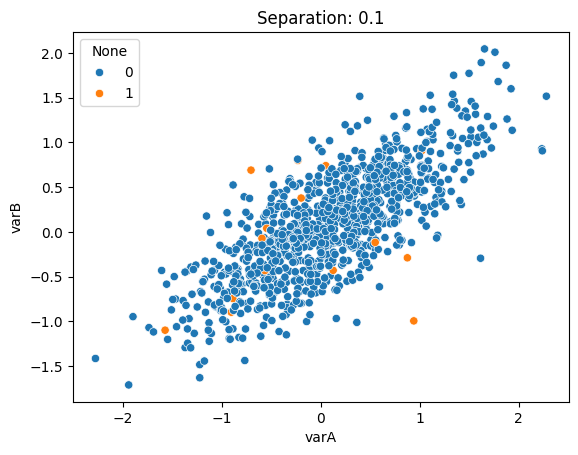

0    983
1     17
Name: count, dtype: int64


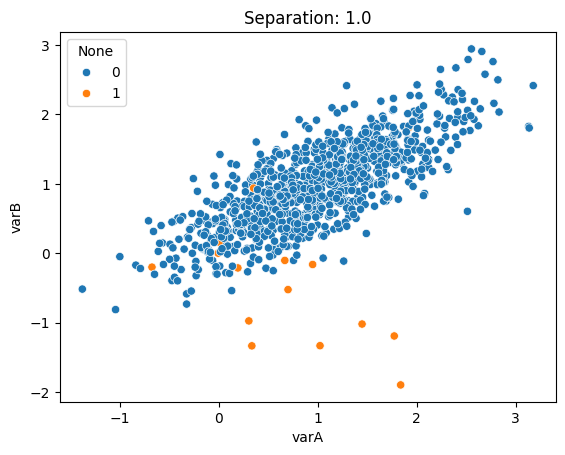

0    983
1     17
Name: count, dtype: int64


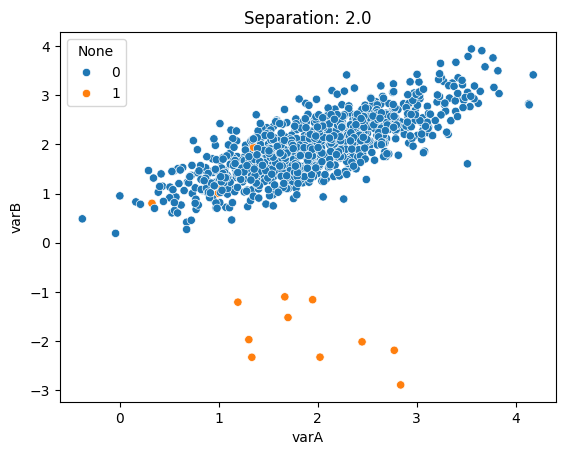

In [3]:
# make datasets with different class separateness
# and plot
for sep in [0.1, 1., 2.]:
    X, y = make_data(sep)
    print(y.value_counts())

    sns.scatterplot(data=X, x='varA', y='varB', hue=y)
    plt.title('Separation: {}'.format(sep))
    plt.show()

As we increase the parameter `sep`, the minority and majority class show less degree of overlap.

## Undersample with Condensed Nearest Neighbours

### Well separated classes

In [4]:
# create data
X, y = make_data(sep=2)

# set up condensed nearest neighbour transformer
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=1,      # default
    n_jobs=4
)

X_resampled, y_resampled = cnn.fit_resample(X, y)

In [5]:
# size of original data
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# size of undersampled data
X_resampled.shape, y_resampled.shape

((70, 2), (70,))

In [7]:
# number of minority class observations
y.value_counts()

0    983
1     17
Name: count, dtype: int64

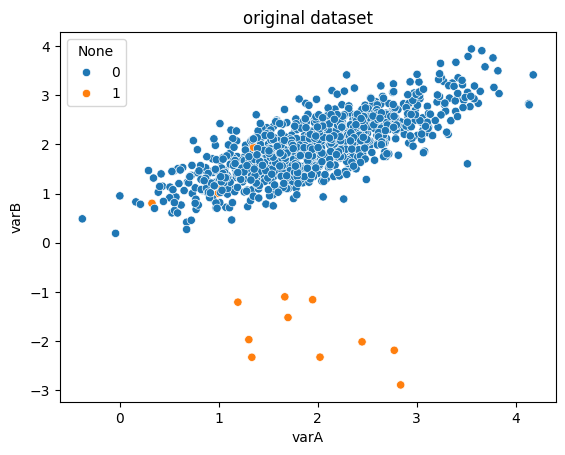

In [8]:
sns.scatterplot(data=X, x='varA', y='varB', hue=y)

plt.title('original dataset')
plt.show()

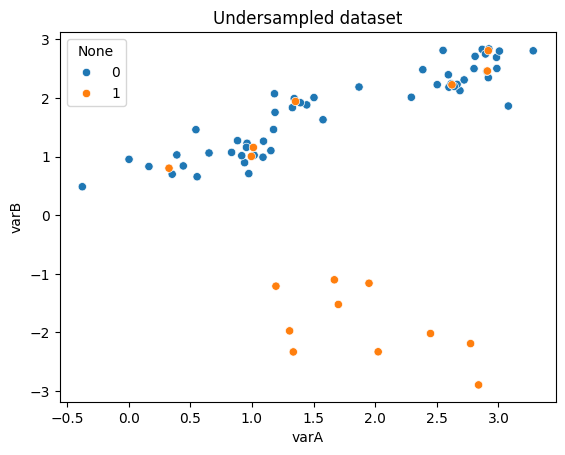

In [9]:
# plot undersampled data
sns.scatterplot(data=X_resampled, x='varA', y='varB', hue=y_resampled)

plt.title('Undersampled dataset')
plt.show()

Condensed Nearest Neighbours retains the observations from the majority class that are more similar to those in the minority class.

Note how values bigger where varA > 3 and varB > 3 have not been included in the undersampled dataset

### Partially separated classes

In [16]:
# create data
X, y = make_data(sep=0.5)

# set up condensed nearest neighbour transformer
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=3,      # changed the number of nearest neighbours
    n_jobs=4
)

X_resampled, y_resampled = cnn.fit_resample(X, y)

In [17]:
# size of original data
X.shape, y.shape

((1000, 2), (1000,))

In [18]:
# size of undersampled data
X_resampled.shape, y_resampled.shape

((64, 2), (64,))

In [19]:
# number of minority class observations
y.value_counts()

0    983
1     17
Name: count, dtype: int64

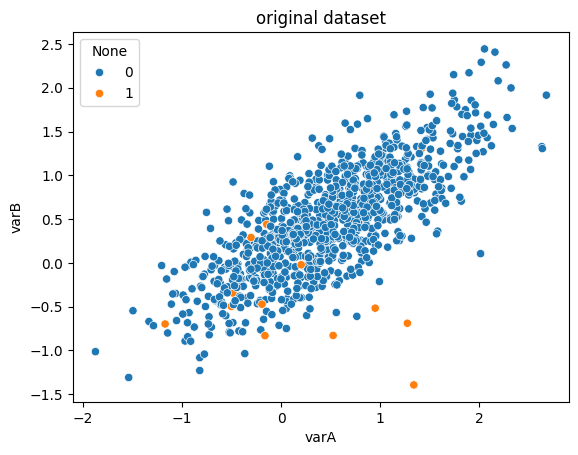

In [20]:
sns.scatterplot(data=X, x='varA', y='varB', hue=y)

plt.title('original dataset')
plt.show()

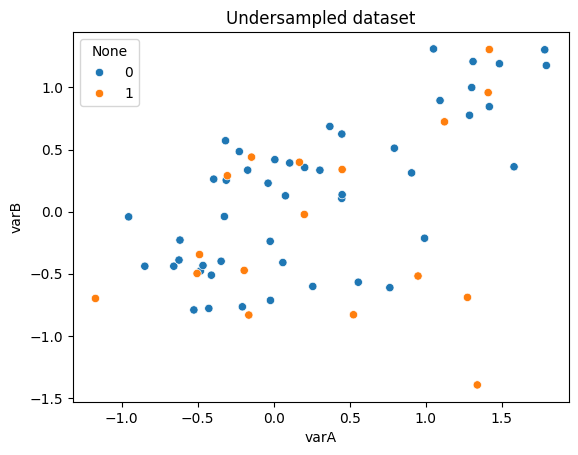

In [21]:
# plot undersampled data
sns.scatterplot(data=X_resampled, x='varA', y='varB', hue=y_resampled)

plt.title('Undersampled dataset')
plt.show()

Note again, how CNN preserves the observations from the majority class that look more similar to those in the minority class.